In [1]:
import pandas as pd
import numpy as np
import os
import datetime
from datetime import timedelta
import seaborn as sns
import matplotlib.pyplot as plt 
from sklearn.metrics import f1_score, make_scorer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline

In [2]:
DS_PATH= './datasets/Rotman_MMA_Summer_Datathon_NWHL.csv'
DS_PATH_RANKS= './datasets/ranks_v_csv.csv'

In [3]:
# We take out the ranks from ranks_v_csv.csv Higher rank the better
df_ranked = pd.read_csv(DS_PATH_RANKS)

In [4]:
os.path.exists(DS_PATH)

True

# Data Analysis

In [5]:
df= pd.read_csv(DS_PATH)

In [6]:
df.head(5)

,game_date,Home Team,Away Team,Period,Clock,Home Team Skaters,Away Team Skaters,Home Team Goals,Away Team Goals,Team,...,Event,X Coordinate,Y Coordinate,Detail 1,Detail 2,Detail 3,Detail 4,Player 2,X Coordinate 2,Y Coordinate 2
0,2021-01-23,Minnesota Whitecaps,Boston Pride,1,20:00,5,5,0,0,Boston Pride,...,Faceoff Win,100,43,Backhand,NaN,NaN,NaN,Stephanie Anderson,NaN,NaN
1,2021-01-23,Minnesota Whitecaps,Boston Pride,1,19:58,5,5,0,0,Boston Pride,...,Puck Recovery,107,40,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2021-01-23,Minnesota Whitecaps,Boston Pride,1,19:57,5,5,0,0,Boston Pride,...,Zone Entry,125,28,Carried,NaN,NaN,NaN,Maddie Rowe,NaN,NaN
3,2021-01-23,Minnesota Whitecaps,Boston Pride,1,19:55,5,5,0,0,Boston Pride,...,Shot,131,28,Snapshot,On Net,t,f,NaN,NaN,NaN
4,2021-01-23,Minnesota Whitecaps,Boston Pride,1,19:53,5,5,0,0,Boston Pride,...,Faceoff Win,169,21,Backhand,NaN,NaN,NaN,Stephanie Anderson,NaN,NaN


In [7]:
#df[df['Event']=='Goal']

df['Goals'] = np.where(df['Event']== 'Goal', True, False) # 0 for goals and 1 for no goals


In [8]:
df['Goals'].value_counts()

False    26806
True        76
Name: Goals, dtype: int64

In [9]:
df['Detail 1'].value_counts()

Direct                       6720
Indirect                     3959
Lost                         1637
Carried                      1267
Snapshot                      888
Wristshot                     718
Backhand                      618
Dumped                        578
Forehand                      227
Slapshot                      227
Retained                      226
Played                         99
Fan                            68
Deflection                     53
Tripping                       34
Wrap Around                    31
Interference                   29
Hooking                        21
Roughing                       19
Holding                        11
Cross-checking                  7
Slashing                        6
Too many men on the ice         4
Illegal Check to the Head       2
Game Misconduct                 2
High-sticking                   2
Unsportsmanlike conduct         2
Charging                        1
Feet                            1
Elbowing      

In [10]:
# Next since its given that most shots are basically missed we will consider on net situation too that means player shot but saved
df['Net'] = np.where(df['Detail 2'] == 'On Net', True, False) # 0 for On Net and 1 for Not on net

In [11]:
df['Net'].value_counts()

False    25933
True       949
Name: Net, dtype: int64

In [12]:
# This way we get even more data for good players since they are not missing
# Now we take missed shots or shots with "Fan" SHots in which stick did'nt hit puck at all this will be taken for all bad cases
df['Missed'] = np.where(df['Detail 2'] == 'Missed', True, False)


In [13]:
df['Missed'].value_counts()
#These missed cases will be taken as negatives in training and feature dependence.


False    26411
True       471
Name: Missed, dtype: int64

In [14]:
# We will also find fan cases in which totally missed and cases which are bad for team
df['Fanned'] = np.where(df['Detail 1'] == 'Fan', True, False)
df['Game_Misconduct'] = np.where(df['Detail 1'] == 'Game Misconduct', True, False)
df['Unsportsmanlike_conduct'] = np.where(df['Detail 1'] == 'Unsportsmanlike conduct', True, False)
#Game Misconduct ,Unsportsmanlike conduct , 

In [15]:
# next for excellent passers We take event in which pass was carried out and led to "on net"
#games_by_date['Event']=='Play'
df['pass'] = np.where(df['Event'] == 'Play', True, False)


In [16]:
#We do the same for Takeaway
df['Takeaway'] = np.where(df['Event'] == 'Takeaway', True, False)

In [17]:
#Same with Puck Recovery
df['Puck_Recovery'] = np.where(df['Event'] == 'Puck Recovery', True, False)

In [18]:
# We need to combine game date and clock to one single notation
df['date_clock']=df['game_date'][0]+"_"+df['Clock']

In [19]:
# get the date of event net and player who scored it make dictionary player :['date_clock1','date_clock2',...]
dict_player_gamedate={}
for i,row in df.iterrows():
    net= row['Net']
    #print(row.Player)
    if net:
        #print(dict_player_gamedate[row['Player']])
        if row['Player'] not in dict_player_gamedate.keys():  #doesnt exist==None:
            dict_player_gamedate[row['Player']]=[]
        #print(dict_player_gamedate[row['Player']])    
        dict_player_gamedate[row['Player']].append(row['date_clock'])
        

In [20]:
dict_player_gamedate.keys() # all scoring players with date_clock when they score

dict_keys(['McKenna Brand', 'Allie Thunstrom', 'Lauren Kelly', 'Haylea Schmid', 'Samantha Davis', 'Jillian Dempsey', 'Jonna Curtis', 'Carlee Turner', 'Christina Putigna', 'Kaleigh Fratkin', 'Lexie Laing', 'Taylor Wenczkowski', 'Audra Richards', 'Mallory Souliotis', 'Haley Mack', 'Mary Parker', 'Meghara McManus', 'Meghan Lorence', 'Nina Rodgers', 'Tori Sullivan', 'Winny Brodt-Brown', 'Sydney Baldwin', 'Stephanie Anderson', 'Alyssa Wohlfeiler', 'Kayla Friesen', 'Jordan Juron', 'Kristin Lewicki', 'Alyson Matteau', 'Autumn MacDougall', 'Katelynn Russ', 'Tori Howran', 'Kaycie Anderson', 'Sarah Schwenzfeier', 'Grace Klienbach', 'Elena Orlando', 'Janine Weber', 'Cassidy MacPherson', 'Iveta Klimasova', 'Amanda Conway', 'Neve Van Pelt', 'Megan Delay', 'Lenka Curmova', 'Emma Vlasic', 'Whitney Dove', 'Maggie LaGue', 'Shannon Doyle', 'Kayla Meneghin', 'Erin Gehen', 'Maddie Bishop', 'Brooke Stacey', 'Taylor Marchin', 'Nicole Guagliardo', 'Mackenzie Lancaster', 'Hunter Accursi', 'Kelly Babstock', 'L

In [21]:
#Pass and shot on net interval 240 seconds from event of 
list_pass_and_shot=[]
for i,row in df.iterrows():
    if row['pass']:
        # Case when we got a pass
        player2= row['Player 2']
        date_clock = row['date_clock']
        if len(date_clock.split('_')[1].split(':')[0])==1:
            date_clock= date_clock.split('_')[0]+'_0'+date_clock.split('_')[1]
        pass_dtime= datetime.datetime.fromisoformat(date_clock)
        pass_dtime_min = pass_dtime - timedelta(seconds=240) 
        pass_dtime_max= pass_dtime + timedelta(seconds=240)
        if player2 in dict_player_gamedate.keys():
            shot_onnet_dtimes_list = dict_player_gamedate[player2]
            val_pass_and_shot= False
            for dtime in shot_onnet_dtimes_list:
                if len(dtime.split('_')[1].split(':')[0])==1:
                    dtime= dtime.split('_')[0]+'_0'+dtime.split('_')[1]
                    #print(dtime)
                shot_onnet_dtime= datetime.datetime.fromisoformat(dtime)
                if pass_dtime_min<shot_onnet_dtime and  shot_onnet_dtime<pass_dtime_max: #pass_dtime_min<shot_onnet_dtime and  
                    #cant ignore lower bound otherwise can be different date
                    val_pass_and_shot= True
                    break
            if val_pass_and_shot:
                list_pass_and_shot.append(True)
            else:
                list_pass_and_shot.append(False)
        else:
            list_pass_and_shot.append(False)
    else:
        list_pass_and_shot.append(False)
        

In [22]:
df['pass_and_shot_onnet'] =list_pass_and_shot

In [23]:
df['pass_and_shot_onnet'].value_counts()

False    26031
True       851
Name: pass_and_shot_onnet, dtype: int64

In [24]:
df['Net'].value_counts()

False    25933
True       949
Name: Net, dtype: int64

In [25]:
df.columns

Index(['game_date', 'Home Team', 'Away Team', 'Period', 'Clock',
       'Home Team Skaters', 'Away Team Skaters', 'Home Team Goals',
       'Away Team Goals', 'Team', 'Player', 'Event', 'X Coordinate',
       'Y Coordinate', 'Detail 1', 'Detail 2', 'Detail 3', 'Detail 4',
       'Player 2', 'X Coordinate 2', 'Y Coordinate 2', 'Goals', 'Net',
       'Missed', 'Fanned', 'Game_Misconduct', 'Unsportsmanlike_conduct',
       'pass', 'Takeaway', 'Puck_Recovery', 'date_clock',
       'pass_and_shot_onnet'],
      dtype='object')

In [26]:
# SO positive or selected players will have true as value in Goals,Net,pass_and_shot_onnet,Takeaway,Puck_Recovery
# Negative or not selected players will have True as value in Missed,Fanned,Game_Misconduct,Unsportsmanlike_conduct

In [27]:
# Now combining all the above to Target variable
df['Target']= (df['Goals'] | df['Net'] | df['pass_and_shot_onnet']  | df['Takeaway'] | df['Puck_Recovery']) &   ~(df['Missed'] | df['Fanned'] | df['Game_Misconduct'] | df['Unsportsmanlike_conduct'])

In [28]:
df.head()

,game_date,Home Team,Away Team,Period,Clock,Home Team Skaters,Away Team Skaters,Home Team Goals,Away Team Goals,Team,...,Missed,Fanned,Game_Misconduct,Unsportsmanlike_conduct,pass,Takeaway,Puck_Recovery,date_clock,pass_and_shot_onnet,Target
0,2021-01-23,Minnesota Whitecaps,Boston Pride,1,20:00,5,5,0,0,Boston Pride,...,False,False,False,False,False,False,False,2021-01-23_20:00,False,False
1,2021-01-23,Minnesota Whitecaps,Boston Pride,1,19:58,5,5,0,0,Boston Pride,...,False,False,False,False,False,False,True,2021-01-23_19:58,False,True
2,2021-01-23,Minnesota Whitecaps,Boston Pride,1,19:57,5,5,0,0,Boston Pride,...,False,False,False,False,False,False,False,2021-01-23_19:57,False,False
3,2021-01-23,Minnesota Whitecaps,Boston Pride,1,19:55,5,5,0,0,Boston Pride,...,False,False,False,False,False,False,False,2021-01-23_19:55,False,True
4,2021-01-23,Minnesota Whitecaps,Boston Pride,1,19:53,5,5,0,0,Boston Pride,...,False,False,False,False,False,False,False,2021-01-23_19:53,False,False


<AxesSubplot:>

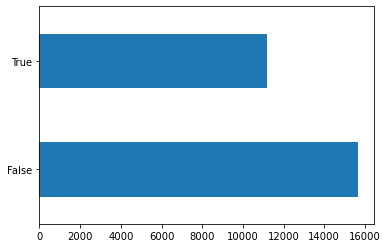

In [29]:
df['Target'].value_counts().plot(kind='barh')

In [30]:
df['Target'].value_counts()

False    15674
True     11208
Name: Target, dtype: int64

In [111]:
df.columns

Index(['game_date', 'Home Team', 'Away Team', 'Period', 'Clock',
       'Home Team Skaters', 'Away Team Skaters', 'Home Team Goals',
       'Away Team Goals', 'Team', 'Player', 'Event', 'X Coordinate',
       'Y Coordinate', 'Detail 1', 'Detail 2', 'Detail 3', 'Detail 4',
       'Player 2', 'X Coordinate 2', 'Y Coordinate 2', 'Goals', 'Net',
       'Missed', 'Fanned', 'Game_Misconduct', 'Unsportsmanlike_conduct',
       'pass', 'Takeaway', 'Puck_Recovery', 'date_clock',
       'pass_and_shot_onnet', 'Target', 'target_ranks'],
      dtype='object')

In [113]:
df[['pass_and_shot_onnet','Player','Player 2']].to_csv('passandsjotonnet_player1_player2.csv')

# We use ranks to create targets

In [32]:
target_ranks=[]
for i,row in df.iterrows():
    name_player = row.Player
    final_rank = df_ranked[df_ranked['Player']==name_player]
    #print(final_rank)
    if float(final_rank['Final Ranks'])>25.0:
        target_ranks.append(1) # 1 means selected
    else:
        target_ranks.append(0) # 0 means not selected

In [33]:
#df_ranked['Final Ranks'].value_counts().plot(kind='barh')


In [34]:
df['target_ranks']=None
df['target_ranks']= target_ranks

In [35]:
df['target_ranks'].value_counts()

1    13716
0    13166
Name: target_ranks, dtype: int64

In [36]:
df_ranked.Player

0         Jillian Dempsey
1           McKenna Brand
2         Tereza Vanisova
3          Samantha Davis
4      Stephanie Anderson
              ...        
121            Caty Flagg
122           Rachael Ade
123          Maeve Reilly
124         Sarah Hughson
125     Mariah Fujimagari
Name: Player, Length: 126, dtype: object

# Now the dataframe is ready for modelling and Feature importances

In [37]:
df_feature_imp_data= df[['Home Team Goals',
       'Away Team Goals','Home Team Skaters', 'Away Team Skaters', 'Detail 1', 'Detail 2']]
'''
, 'Net',
       'Missed', 'Fanned', 'Game_Misconduct', 'Unsportsmanlike_conduct',
       'pass', 'pass_and_shot_onnet', 'Takeaway',
       'Puck_Recovery'
'Home Team', 'Away Team',
'''


"\n, 'Net',\n       'Missed', 'Fanned', 'Game_Misconduct', 'Unsportsmanlike_conduct',\n       'pass', 'pass_and_shot_onnet', 'Takeaway',\n       'Puck_Recovery'\n'Home Team', 'Away Team',\n"

In [38]:
df_feature_imp_data_dummies= df_feature_imp_data.copy()

In [39]:
def get_dummies_and_concat(df,key):
    dummies = pd.get_dummies(df[key])
 
    # Concatenate the dummies to original dataframe
    merged = pd.concat([df, dummies], axis='columns')

    # drop the values
    merged.drop([key], axis='columns')
    return merged

In [40]:
# Now we need to convert all to categorical dummies
# From important features data we take in 

In [41]:
coloumns_to_make_dummies= ['Detail 1', 'Detail 2']#'Home Team', 'Away Team',
dummies = pd.get_dummies(df_feature_imp_data_dummies[coloumns_to_make_dummies])
df_feature_imp_data_dummies = pd.concat([df_feature_imp_data_dummies, dummies], axis='columns')
df_feature_imp_data_dummies=df_feature_imp_data_dummies.drop(coloumns_to_make_dummies, axis='columns')
#for col_name in coloumns_to_make_dummies:
#    df_feature_imp_data_dummies= get_dummies_and_concat(df_feature_imp_data_dummies,col_name)

In [42]:
df_feature_imp_data_dummies.columns

Index(['Home Team Goals', 'Away Team Goals', 'Home Team Skaters',
       'Away Team Skaters', 'Detail 1_Backhand', 'Detail 1_Carried',
       'Detail 1_Charging', 'Detail 1_Cross-checking', 'Detail 1_Deflection',
       'Detail 1_Direct', 'Detail 1_Dumped', 'Detail 1_Elbowing',
       'Detail 1_Face-off violation', 'Detail 1_Fan', 'Detail 1_Feet',
       'Detail 1_Forehand', 'Detail 1_Game Misconduct',
       'Detail 1_Goalkeeper interference', 'Detail 1_High-sticking',
       'Detail 1_Holding', 'Detail 1_Holding the stick', 'Detail 1_Hooking',
       'Detail 1_Illegal Check to the Head', 'Detail 1_Indirect',
       'Detail 1_Interference', 'Detail 1_Lost', 'Detail 1_Played',
       'Detail 1_Retained', 'Detail 1_Roughing', 'Detail 1_Slapshot',
       'Detail 1_Slashing', 'Detail 1_Snapshot',
       'Detail 1_Too many men on the ice', 'Detail 1_Tripping',
       'Detail 1_Unsportsmanlike conduct', 'Detail 1_Wrap Around',
       'Detail 1_Wristshot', 'Detail 2_Blocked', 'Detail 2_Misse

In [43]:


#Calculating correlations and dropping repetitive values
corr_mat=df_feature_imp_data_dummies.corr().round(2)

upper=corr_mat.where(np.triu(np.ones(corr_mat.shape),k=1).astype(np.bool))
to_drop=[column for column in upper.columns if any(upper[column]>0.95)]
df_feature_imp_data_dummies=df_feature_imp_data_dummies.drop(columns = to_drop)



C:\Users\predator\AppData\Local\Temp\ipykernel_38504\1265141509.py:4: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper=corr_mat.where(np.triu(np.ones(corr_mat.shape),k=1).astype(np.bool))


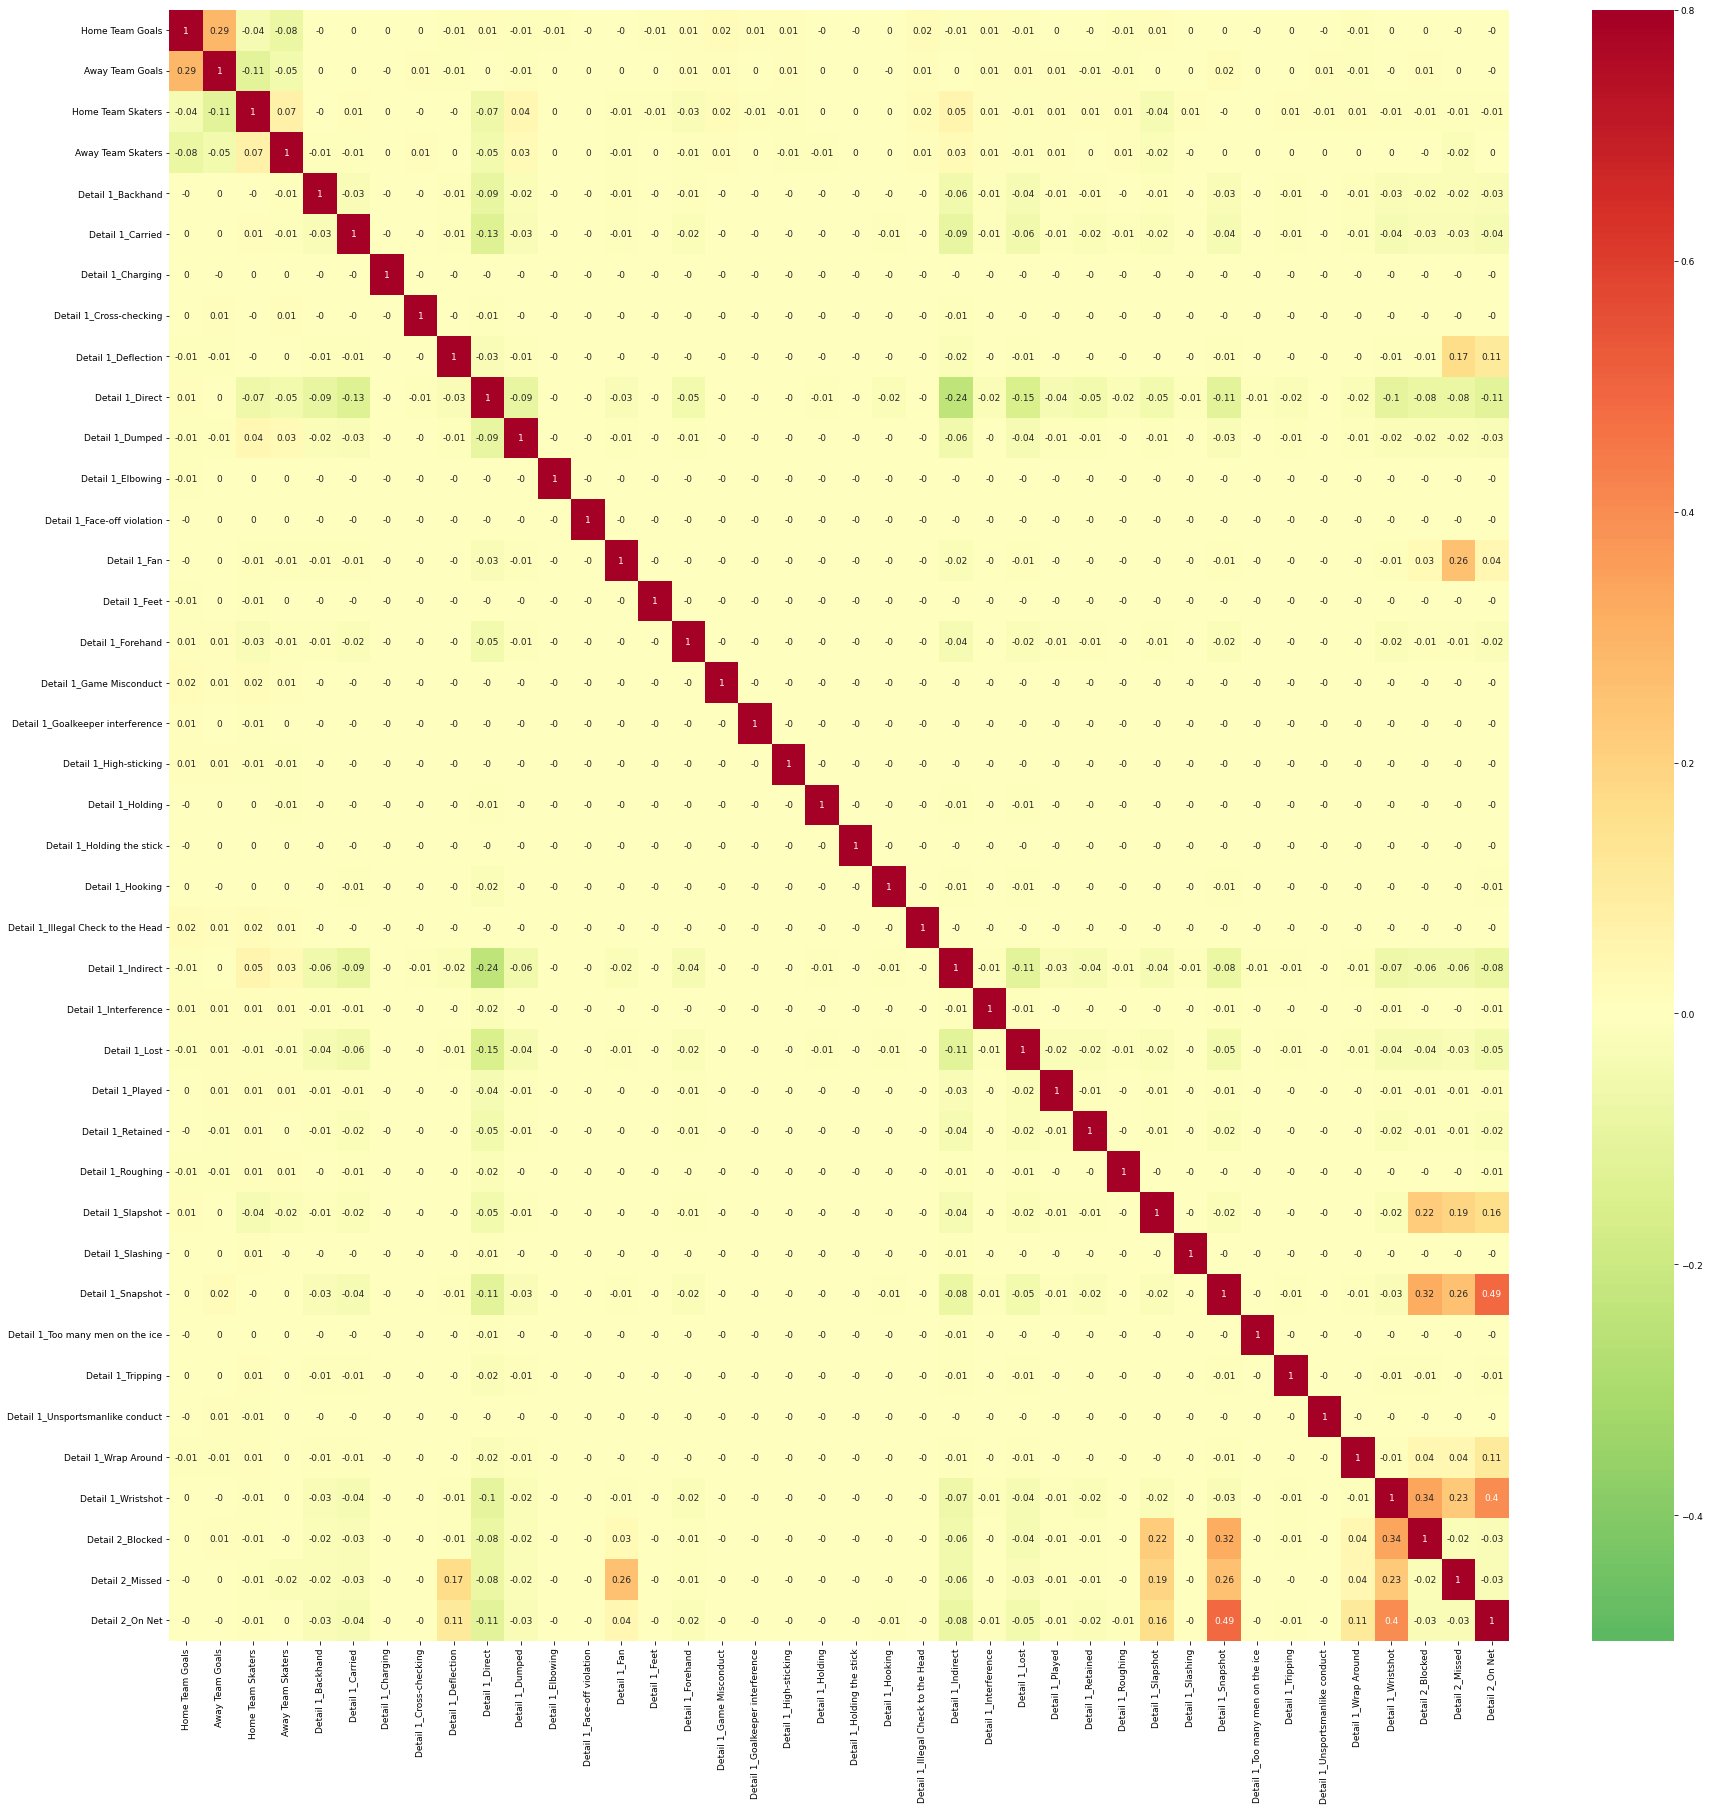

In [44]:
corr_mat=df_feature_imp_data_dummies.corr().round(2)

# Draw a correlation heatmap
plt.rcParams['font.size'] = 9
plt.figure(figsize = (30, 30))

sns.heatmap(corr_mat, vmin = -0.5, vmax = 0.8, center = 0, 
            cmap = plt.cm.RdYlGn_r, annot = True);

# Now we have our data and df['Target'] and df['target_ranks'] we can start with feature importances
  # False 0 and True=1)

In [45]:
scorer=make_scorer(f1_score,greater_is_better=True,average='macro')
df_feature_imp_data_dummies['target_ranks'] = df['target_ranks'].astype(int) #False 0 and True=1)
df_feature_imp_data_dummies['Player'] = df['Player']
'''
df_feature_imp_data_dummies['Net'] = df_feature_imp_data_dummies['Net'].astype(int)
df_feature_imp_data_dummies['Missed'] = df_feature_imp_data_dummies['Missed'].astype(int)
df_feature_imp_data_dummies['Fanned'] = df_feature_imp_data_dummies['Fanned'].astype(int)
df_feature_imp_data_dummies['Game_Misconduct'] = df_feature_imp_data_dummies['Game_Misconduct'].astype(int)
df_feature_imp_data_dummies['Unsportsmanlike_conduct'] = df_feature_imp_data_dummies['Unsportsmanlike_conduct'].astype(int)
df_feature_imp_data_dummies['pass'] = df_feature_imp_data_dummies['pass'].astype(int)
df_feature_imp_data_dummies['pass_and_shot_onnet'] = df_feature_imp_data_dummies['pass_and_shot_onnet'].astype(int)
df_feature_imp_data_dummies['Takeaway'] = df_feature_imp_data_dummies['Takeaway'].astype(int)
df_feature_imp_data_dummies['Puck_Recovery'] = df_feature_imp_data_dummies['Puck_Recovery'].astype(int)
'''
#Divide data into test and train
train, test = train_test_split(df_feature_imp_data_dummies, test_size=0.2)

In [46]:
# Extract the training data
train_labels = np.array(train['target_ranks']) 
train_set = train.drop(columns = ['target_ranks'])
test_labels = np.array(test['target_ranks']) 
test_set = test.drop(columns = ['target_ranks'])
print(test_set.shape)

(5377, 41)


In [47]:
#train_set.dtypes
train_ids=  np.array(train['Player']) 
train_set = train_set.drop(columns = ['Player'])
test_ids=  np.array(test['Player']) 
test_set = test_set.drop(columns = ['Player'])


In [48]:
pipeline=Pipeline([('imputer',SimpleImputer(strategy='median')),
                  ('scaler',MinMaxScaler())])
features=list(train_set.columns)
train_set=pipeline.fit_transform(train_set)
test_set=pipeline.transform(test_set)

In [49]:
model=RandomForestClassifier(n_estimators=100,random_state=10,n_jobs=-1)
cv_score=cross_val_score(model,train_set,train_labels,cv=10,scoring=scorer)
print(f'10 Fold Cross Validation F1 Score = {round(cv_score.mean(), 4)} with std = {round(cv_score.std(), 4)}')

10 Fold Cross Validation F1 Score = 0.5538 with std = 0.0101


In [50]:
model.fit(train_set,train_labels)

#Feature importances into a dataframe

feature_importances=pd.DataFrame({'feature':features,'importance':model.feature_importances_})
feature_importances.head()

,feature,importance
0,Home Team Goals,0.244307
1,Away Team Goals,0.251831
2,Home Team Skaters,0.099393
3,Away Team Skaters,0.110916
4,Detail 1_Backhand,0.018832


In [51]:
def plot_feature_importances(df, n = 10, threshold = None):
    """Plots n most important features. Also plots the cumulative importance if
    threshold is specified and prints the number of features needed to reach threshold cumulative importance.
    Intended for use with any tree-based feature importances. 
    
    Args:
        df (dataframe): Dataframe of feature importances. Columns must be "feature" and "importance".
    
        n (int): Number of most important features to plot. Default is 15.
    
        threshold (float): Threshold for cumulative importance plot. If not provided, no plot is made. Default is None.
        
    Returns:
        df (dataframe): Dataframe ordered by feature importances with a normalized column (sums to 1) 
                        and a cumulative importance column
    
    Note:
    
        * Normalization in this case means sums to 1. 
        * Cumulative importance is calculated by summing features from most to least important
        * A threshold of 0.9 will show the most important features needed to reach 90% of cumulative importance
    
    """
    plt.style.use('fivethirtyeight')
    
    # Sort features with most important at the head
    df = df.sort_values('importance', ascending = False).reset_index(drop = True)
    
    # Normalize the feature importances to add up to one and calculate cumulative importance
    df['importance_normalized'] = df['importance'] / df['importance'].sum()
    df['cumulative_importance'] = np.cumsum(df['importance_normalized'])
    
    plt.rcParams['font.size'] = 12
    
    # Bar plot of n most important features
    df.loc[:n, :].plot.barh(y = 'importance_normalized', 
                            x = 'feature', color = 'darkgreen', 
                            edgecolor = 'k', figsize = (12, 8),
                            legend = False, linewidth = 2)

    plt.xlabel('Normalized Importance', size = 18); plt.ylabel(''); 
    plt.title(f'{n} Most Important Features', size = 18)
    plt.gca().invert_yaxis()
    
    
    if threshold:
        # Cumulative importance plot
        plt.figure(figsize = (8, 6))
        plt.plot(list(range(len(df))), df['cumulative_importance'], 'b-')
        plt.xlabel('Number of Features', size = 16); plt.ylabel('Cumulative Importance', size = 16); 
        plt.title('Cumulative Feature Importance', size = 18);
        
        # Number of features needed for threshold cumulative importance
        # This is the index (will need to add 1 for the actual number)
        importance_index = np.min(np.where(df['cumulative_importance'] > threshold))
        
        # Add vertical line to plot
        plt.vlines(importance_index + 1, ymin = 0, ymax = 1.05, linestyles = '--', colors = 'red')
        plt.show();
        
        print('{} features required for {:.0f}% of cumulative importance.'.format(importance_index + 1, 
                                                                                  100 * threshold))
    
    return df

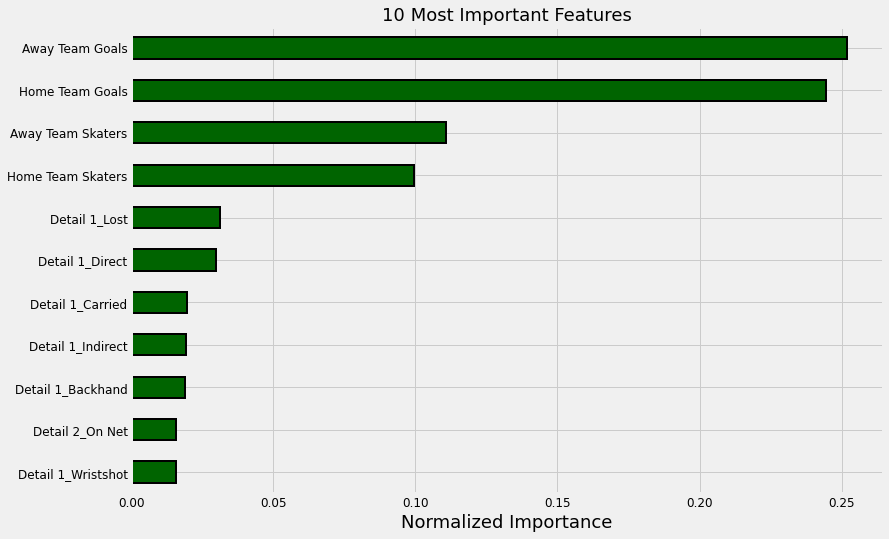

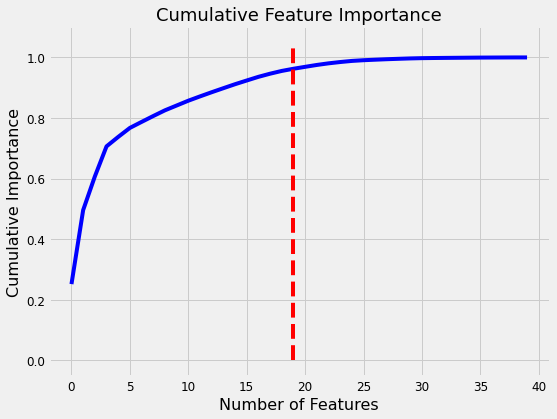

19 features required for 95% of cumulative importance.


In [52]:
norm_fi = plot_feature_importances(feature_importances, threshold=0.95)
#This is 10 most important features plots and it is actually making a lot of sense [Just take a look at features it selected] 


***However, feature importances don't tell us which direction of the feature is important (for example, we can't use these to tell whether more or less Detail 1 direct leads to player selected) they only tell us which features the model considered relevant.***

In [53]:
def kde_target(df, variable):
    """Plots the distribution of `variable` in `df` colored by the `Target` column"""
    
    colors = {0: 'green', 1: 'red'}

    plt.figure(figsize = (12, 8))
    
    df = df[df['target_ranks'].notnull()]
    
    for level in df['target_ranks'].unique():
        subset = df[df['target_ranks'] == level].copy()
        sns.kdeplot(subset[variable].dropna(), 
                    label = f'target_ranks : {level}', 
                    color = colors[int(subset['target_ranks'].unique())])

    plt.xlabel(variable); plt.ylabel('Density');
    plt.title('{} Distribution'.format(variable.capitalize()));

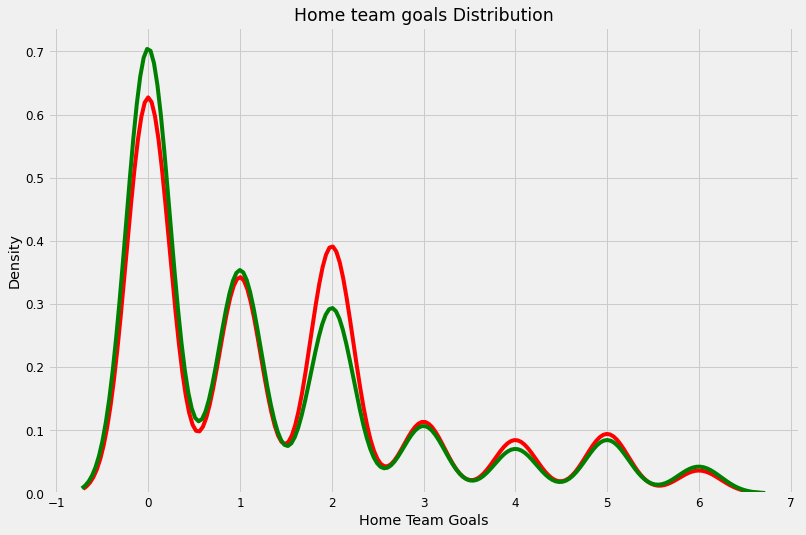

In [54]:
kde_target(df_feature_imp_data_dummies, 'Home Team Goals')

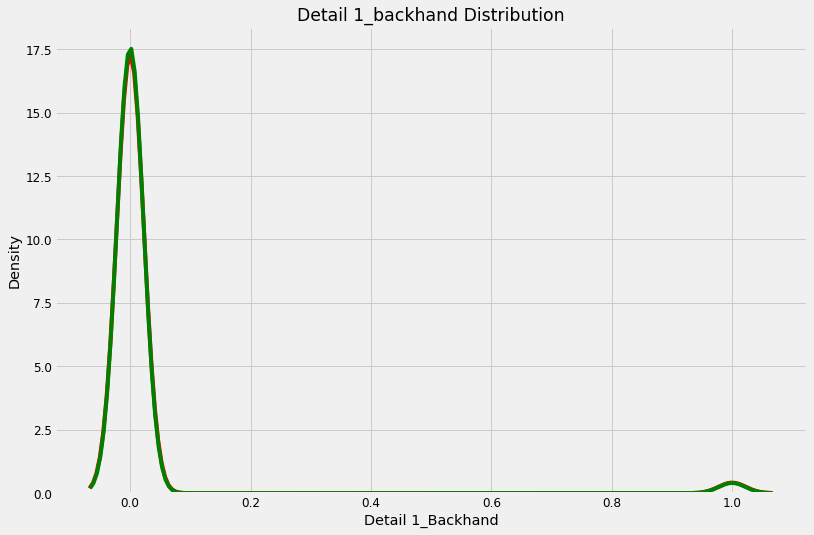

In [55]:
kde_target(df_feature_imp_data_dummies, 'Detail 1_Backhand')

# Start with modelling


In [56]:
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegressionCV, RidgeClassifierCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier

In [57]:
import warnings 
from sklearn.exceptions import ConvergenceWarning

# Filter out warnings from models
warnings.filterwarnings('ignore', category = ConvergenceWarning)
warnings.filterwarnings('ignore', category = DeprecationWarning)
warnings.filterwarnings('ignore', category = UserWarning)

# Dataframe to hold results
model_results = pd.DataFrame(columns = ['model', 'cv_mean', 'cv_std'])

def cv_model(train, train_labels, model, name, model_results=None):
    """Perform 10 fold cross validation of a model"""
    
    cv_scores = cross_val_score(model, train, train_labels, cv = 10, scoring=scorer, n_jobs = -1)
    print(f'10 Fold CV Score: {round(cv_scores.mean(), 5)} with std: {round(cv_scores.std(), 5)}')
    
    if model_results is not None:
        model_results = model_results.append(pd.DataFrame({'model': name, 
                                                           'cv_mean': cv_scores.mean(), 
                                                            'cv_std': cv_scores.std()},
                                                           index = [0]),
                                             ignore_index = True)

        return model_results

In [58]:
model_results = cv_model(train_set, train_labels, LinearSVC(), 
                         'LSVC', model_results)

10 Fold CV Score: 0.54325 with std: 0.01422


C:\Users\predator\AppData\Local\Temp\ipykernel_38504\3454154062.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_results = model_results.append(pd.DataFrame({'model': name,


In [59]:
model_results = cv_model(train_set, train_labels, 
                         GaussianNB(), 'GNB', model_results)

10 Fold CV Score: 0.34263 with std: 0.00743


C:\Users\predator\AppData\Local\Temp\ipykernel_38504\3454154062.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_results = model_results.append(pd.DataFrame({'model': name,


In [60]:
model_results = cv_model(train_set, train_labels, 
                         MLPClassifier(hidden_layer_sizes=(32, 64, 128, 64, 32)),
                         'MLP', model_results)

10 Fold CV Score: 0.55359 with std: 0.0117


C:\Users\predator\AppData\Local\Temp\ipykernel_38504\3454154062.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_results = model_results.append(pd.DataFrame({'model': name,


In [61]:
model_results = cv_model(train_set, train_labels, 
                          LinearDiscriminantAnalysis(), 
                          'LDA', model_results)

10 Fold CV Score: 0.54325 with std: 0.01449


C:\Users\predator\AppData\Local\Temp\ipykernel_38504\3454154062.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_results = model_results.append(pd.DataFrame({'model': name,


In [62]:
model_results = cv_model(train_set, train_labels, 
                         RidgeClassifierCV(), 'RIDGE', model_results)

10 Fold CV Score: 0.54291 with std: 0.01429


C:\Users\predator\AppData\Local\Temp\ipykernel_38504\3454154062.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_results = model_results.append(pd.DataFrame({'model': name,


In [63]:
for n in [5, 10, 20]:
    print(f'\nKNN with {n} neighbors\n')
    model_results = cv_model(train_set, train_labels, 
                             KNeighborsClassifier(n_neighbors = n),
                             f'knn-{n}', model_results)


KNN with 5 neighbors

10 Fold CV Score: 0.52498 with std: 0.01007

KNN with 10 neighbors



C:\Users\predator\AppData\Local\Temp\ipykernel_38504\3454154062.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_results = model_results.append(pd.DataFrame({'model': name,


10 Fold CV Score: 0.52669 with std: 0.00815

KNN with 20 neighbors



C:\Users\predator\AppData\Local\Temp\ipykernel_38504\3454154062.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_results = model_results.append(pd.DataFrame({'model': name,


10 Fold CV Score: 0.54398 with std: 0.00329


C:\Users\predator\AppData\Local\Temp\ipykernel_38504\3454154062.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_results = model_results.append(pd.DataFrame({'model': name,


In [64]:
from sklearn.ensemble import ExtraTreesClassifier

model_results = cv_model(train_set, train_labels, 
                         ExtraTreesClassifier(n_estimators = 100, random_state = 10),
                         'EXT', model_results)

10 Fold CV Score: 0.55209 with std: 0.01051


C:\Users\predator\AppData\Local\Temp\ipykernel_38504\3454154062.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_results = model_results.append(pd.DataFrame({'model': name,


In [65]:
model_results

,model,cv_mean,cv_std
0,LSVC,0.543254,0.014223
1,GNB,0.342629,0.007431
2,MLP,0.55359,0.011695
3,LDA,0.543254,0.014487
4,RIDGE,0.54291,0.014289
5,knn-5,0.524976,0.010071
6,knn-10,0.526687,0.008147
7,knn-20,0.543983,0.003292
8,EXT,0.552086,0.010511


In [66]:
model_results = cv_model(train_set, train_labels,
                          RandomForestClassifier(100, random_state=10),
                              'RF', model_results)

10 Fold CV Score: 0.55383 with std: 0.0101


C:\Users\predator\AppData\Local\Temp\ipykernel_38504\3454154062.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_results = model_results.append(pd.DataFrame({'model': name,


In [67]:
import xgboost as xgb
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
from sklearn.metrics import accuracy_score
#model = XGBClassifier()
#model.fit(train, train_labels)
space={'max_depth': hp.quniform("max_depth", 3, 18, 1),
        'gamma': hp.uniform ('gamma', 1,9),
        'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_estimators': 180,
        'seed': 0
    }

In [68]:
def objective(space):
    clf=xgb.XGBClassifier(
                    n_estimators =space['n_estimators'], max_depth = int(space['max_depth']), gamma = space['gamma'],
                    reg_alpha = int(space['reg_alpha']),min_child_weight=int(space['min_child_weight']),
                    colsample_bytree=int(space['colsample_bytree']))
    
    evaluation = [( test_set, test_labels)]
    
    clf.fit(train_set, train_labels,
            eval_set=evaluation, eval_metric="auc",
            early_stopping_rounds=10,verbose=False)
    

    pred = clf.predict(test_set)
    accuracy = accuracy_score(test_labels, pred>0.5)
    print ("SCORE:", accuracy)
    return {'loss': -accuracy, 'status': STATUS_OK }

In [69]:
trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 100,
                        trials = trials)

SCORE:                                                                                                                 
0.5616514785196206                                                                                                     
SCORE:                                                                                                                 
0.5616514785196206                                                                                                     
SCORE:                                                                                                                 
0.5092058768830203                                                                                                     
SCORE:                                                                                                                 
0.5616514785196206                                                                                                     
SCORE:                                  

In [70]:
print("The best hyperparameters are : ","\n")
print(best_hyperparams)
space.update(best_hyperparams)

The best hyperparameters are :  

{'colsample_bytree': 0.7341793390163975, 'gamma': 5.443126978916079, 'max_depth': 12.0, 'min_child_weight': 8.0, 'reg_alpha': 138.0, 'reg_lambda': 0.892051475295396}


In [71]:
clf=xgb.XGBClassifier(
                    n_estimators =space['n_estimators'], max_depth = int(space['max_depth']), gamma = space['gamma'],
                    reg_alpha = int(space['reg_alpha']),min_child_weight=int(space['min_child_weight']),
                    colsample_bytree=int(space['colsample_bytree']))

In [72]:
space

{'max_depth': 12.0,
 'gamma': 5.443126978916079,
 'reg_alpha': 138.0,
 'reg_lambda': 0.892051475295396,
 'colsample_bytree': 0.7341793390163975,
 'min_child_weight': 8.0,
 'n_estimators': 180,
 'seed': 0}

In [73]:

#clf=xgb.XGBClassifier(best_hyperparams)
model_results = cv_model(train_set, train_labels,
                          clf,
                              'xgb', model_results)

10 Fold CV Score: 0.53805 with std: 0.00988


C:\Users\predator\AppData\Local\Temp\ipykernel_38504\3454154062.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_results = model_results.append(pd.DataFrame({'model': name,


In [74]:
[x for x in model_results.index] 

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

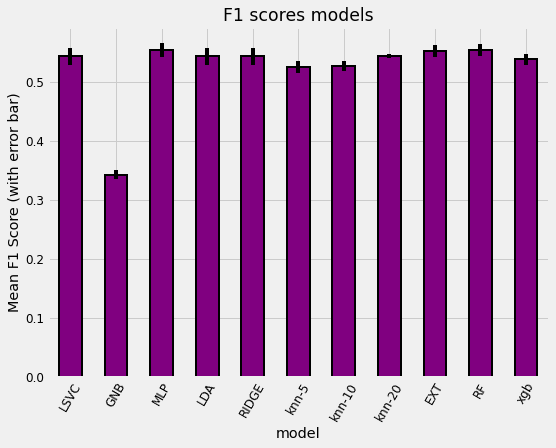

In [75]:
model_results.set_index('model',inplace=True)
model_results['cv_mean'].plot.bar(color='purple',figsize=(8,6),
                                 yerr=list(model_results['cv_std']),
                                 edgecolor='k',linewidth=2)
plt.xticks([0,1,2,3,4,5,6,7,8,9,10],[x for x in model_results.index ],rotation=60)
plt.title("F1 scores models")
plt.ylabel('Mean F1 Score (with error bar)');
model_results.reset_index(inplace = True)

In [76]:
def generate_preds(model, train, train_labels, test, test_ids):
    """Train and test a model on the dataset"""
    
    # Train on the data
    
    model.fit(train, train_labels)
    predictions = model.predict(test)
    predictions = pd.DataFrame({'player_name': test_ids,
                               'Target': predictions})

    return predictions

In [77]:
clf= MLPClassifier(hidden_layer_sizes=(32, 64, 128, 64, 32)) #KNeighborsClassifier(n_neighbors = 20)

In [78]:
predictions=generate_preds(clf,train_set, train_labels,test_set,test_ids)

In [79]:
from sklearn.metrics import confusion_matrix
cf_matrix = confusion_matrix(test_labels, predictions.Target)

<AxesSubplot:>

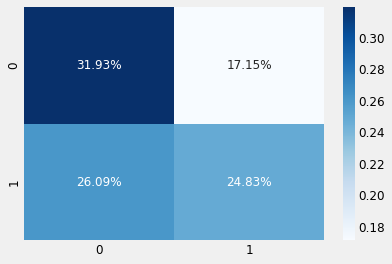

In [80]:
import seaborn as sns
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

# Further Analysis

In [105]:
# zone entry, takeaway, puck recovery, dumpin/out positive , faceoff positive

In [8]:
from hockey_rink import NWHLRink

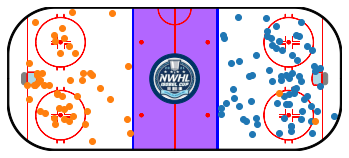

In [9]:
game_df = df.loc[(df["Home Team"] == "Minnesota Whitecaps") & (df["Away Team"] == "Boston Pride")]
shots = game_df.loc[(game_df.Event.isin(["Shot", "Goal"]))]
boston_shots = shots[shots.Team == "Boston Pride"]
minnesota_shots = shots[shots.Team == "Minnesota Whitecaps"]
rink = NWHLRink(x_shift=100, y_shift=42.5, nzone={"length": 50})
ax = rink.draw()
rink.scatter(boston_shots["X Coordinate"], boston_shots["Y Coordinate"])
rink.scatter(200 - minnesota_shots["X Coordinate"], 85 - minnesota_shots["Y Coordinate"])

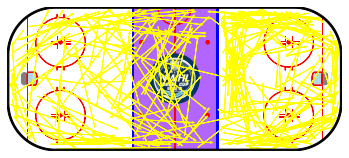

In [10]:
boston_passes = game_df.loc[(game_df.Team == "Boston Pride") & (game_df.Event == "Play")]
ax.clear()
rink.draw()
arrows = rink.arrow(boston_passes["X Coordinate"], boston_passes["Y Coordinate"], 
                    boston_passes["X Coordinate 2"], boston_passes["Y Coordinate 2"], color="yellow")

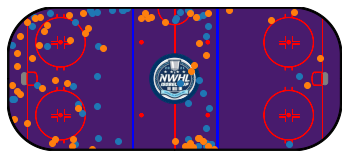

In [33]:
# We want to display zones where most of the takeaways happened
game_df = df.loc[(df["Home Team"] == "Minnesota Whitecaps") & (df["Away Team"] == "Boston Pride")]
takeaways = game_df.loc[(game_df.Event.isin(["Dump In/Out","Goal"]))]
boston_takeaways = takeaways[takeaways.Team == "Boston Pride"]
minnesota_takeaways = takeaways[takeaways.Team == "Minnesota Whitecaps"]
rink = NWHLRink(x_shift=100, y_shift=42.5, nzone={"length": 50})
ax = rink.draw()
rink.scatter(boston_takeaways["X Coordinate"], boston_takeaways["Y Coordinate"])
rink.contour(boston_takeaways["X Coordinate"], boston_takeaways["Y Coordinate"])
rink.contour(minnesota_takeaways["X Coordinate"], minnesota_takeaways["Y Coordinate"])
rink.scatter(minnesota_takeaways["X Coordinate"], minnesota_takeaways["Y Coordinate"])

In [34]:
pbp= df.copy()

In [14]:
pbp.columns

Index(['game_date', 'Home Team', 'Away Team', 'Period', 'Clock',
       'Home Team Skaters', 'Away Team Skaters', 'Home Team Goals',
       'Away Team Goals', 'Team', 'Player', 'Event', 'X Coordinate',
       'Y Coordinate', 'Detail 1', 'Detail 2', 'Detail 3', 'Detail 4',
       'Player 2', 'X Coordinate 2', 'Y Coordinate 2'],
      dtype='object')

In [13]:
pbp.Event.value_counts()

Puck Recovery      8214
Play               7249
Incomplete Play    3430
Zone Entry         1944
Shot               1909
Dump In/Out        1863
Takeaway           1207
Faceoff Win         846
Penalty Taken       144
Goal                 76
Name: Event, dtype: int64